In [ ]:
#test, jak pojedyncze modele radzą sobie z moimi danymi - wybór 4. najlepszych do dalszego tuningu

In [3]:
#!pip install lightgbm catboost imbalanced-learn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
np.random.seed = 42

In [5]:
df = pd.read_csv('learning_set.csv')
df.head()

,Age,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Total_Exposure,Cigarettes_Total,Age_Smoking_Effect,Smoking_Burden,Exposure_Index,Health_Risk_Score,Gender_Female,Gender_Male
0,80,30,29,0,0,0,0,1,0,0,1,317550,2400,317550,32.0,80.0,0,1
1,53,0,0,1,0,0,0,1,0,0,1,0,0,1000,2.0,53.0,0,1
2,47,12,6,1,0,0,1,0,0,0,1,26280,564,54560,7.0,47.0,0,1
3,39,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,44.0,1,0
4,44,0,0,1,0,0,1,1,0,0,2,0,0,2000,3.0,44.0,1,0


In [6]:
# Zakładamy, że kolumna celu nazywa się:
target_column = 'Lung_Cancer_Diagnosis'

X = df.drop(columns=[target_column])
y = df[target_column]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,        # zachowujemy proporcje klas!
    random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")


Train size: (149600, 17), Test size: (64115, 17)
Train class distribution:
Lung_Cancer_Diagnosis
0    0.960401
1    0.039599
Name: proportion, dtype: float64
Test class distribution:
Lung_Cancer_Diagnosis
0    0.960399
1    0.039601
Name: proportion, dtype: float64


In [16]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")


models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=1000, max_depth=10),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, subsample=0.8, learning_rate=0.05, n_estimators=1000),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1),
    "LightGBM": LGBMClassifier(random_state=42, scale_pos_weight=20, num_leaves=31, learning_rate=0.05),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42, scale_pos_weight=20, iterations=1000, learning_rate=0.05),
    "KNN": KNeighborsClassifier(n_neighbors=15, metric='manhattan'),
    "Naive Bayes": GaussianNB(var_smoothing=1e-9),
    "MLP": MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50), activation='relu')
}

results = []

for name, model in models.items():
    print(f"⏳ Start treningu modelu: {name}")
    start_time = time.time()

    model.fit(X_train, y_train)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"✅ Zakończono trening modelu: {name} ({elapsed:.2f} sekundy)\n")    
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    results.append({
        "Model": name,
        "Precision (1)": report['1']['precision'],
        "Recall (1)": report['1']['recall'],
        "F1-score (1)": report['1']['f1-score'],
        "Accuracy": report['accuracy'],
        "Confusion Matrix": cm
    })

# Wyświetlenie podsumowania
df_results = pd.DataFrame(results).sort_values(by="F1-score (1)", ascending=False)
print(df_results[["Model", "Accuracy", "Precision (1)", "Recall (1)", "F1-score (1)"]])


⏳ Start treningu modelu: Random Forest
✅ Zakończono trening modelu: Random Forest (136.52 sekundy)

⏳ Start treningu modelu: Gradient Boosting
✅ Zakończono trening modelu: Gradient Boosting (144.73 sekundy)

⏳ Start treningu modelu: Logistic Regression
✅ Zakończono trening modelu: Logistic Regression (8.50 sekundy)

⏳ Start treningu modelu: LightGBM
[LightGBM] [Info] Number of positive: 5924, number of negative: 143676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 149600, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039599 -> initscore=-3.188549
[LightGBM] [Info] Start training from score -3.188549
✅ Zakończono trening modelu: LightGBM (0.37 sekundy)

⏳ Start treningu modelu: CatBoost
✅

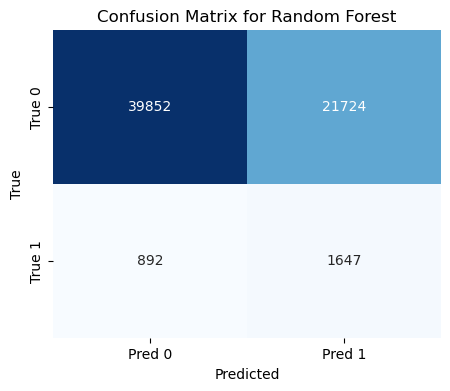

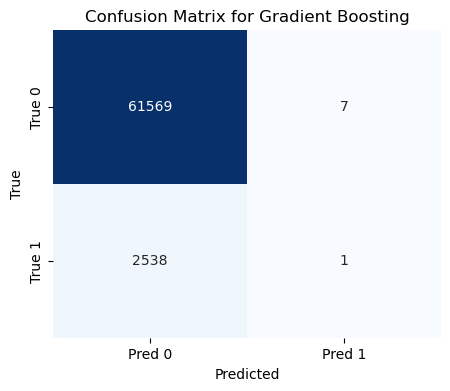

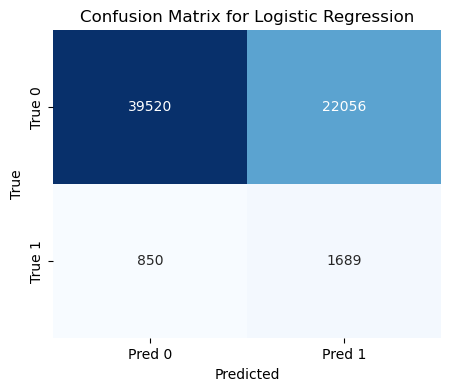

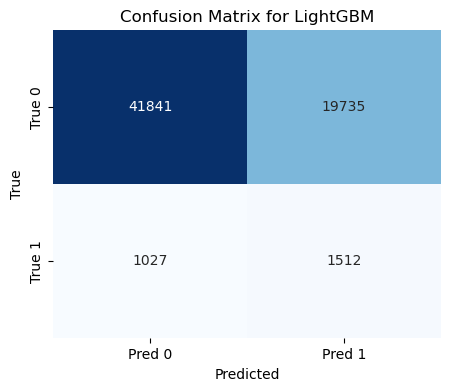

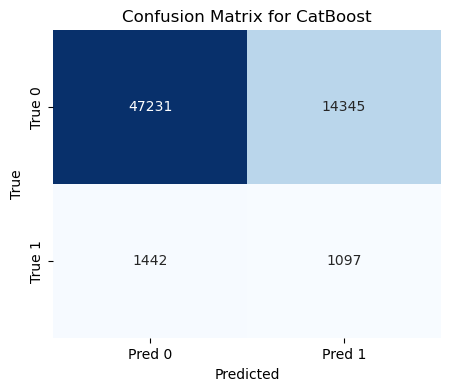

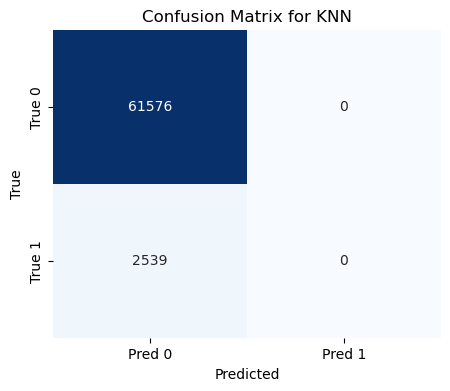

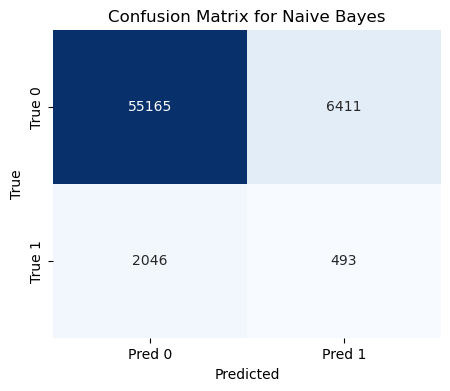

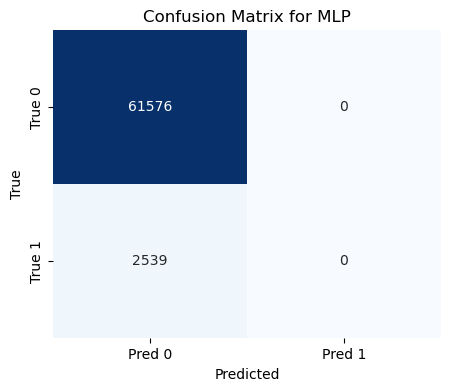

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Określenie pożądanej kolejności modeli


# Posortowanie wyników w results według pożądanej kolejności

# Rysowanie confusion matrix dla każdego modelu w posortowanej kolejności
for result in results:
    model_name = result["Model"]
    cm = result["Confusion Matrix"]
    
    # Tworzymy figurę dla macierzy pomyłek
    plt.figure(figsize=(5, 4))
    
    # Używamy seaborn do wygenerowania heatmapy confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, 
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()